In [11]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage.util import random_noise
import pyfastnoisesimd as fns
import mrcfile

def standardize(X):
    mean = X.mean()
    std = X.std()
    new_X = (X - mean) / std

    return new_X

def clip(X, low=0.005, high=0.995):
    # works with tensors =)
    return np.clip(X, np.quantile(X, low), np.quantile(X, high))

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Make dummy tomograms

Original Tomogram shape: (464, 928, 928)
Output Tomogram shape: (232, 464, 464)


(array([4.0000000e+00, 2.3000000e+01, 1.1100000e+02, 5.2800000e+02,
        6.6830000e+03, 3.0445050e+06, 4.5011349e+07, 1.8772490e+06,
        8.1660000e+03, 5.4000000e+01]),
 array([-25.317186 , -21.403353 , -17.489521 , -13.575688 ,  -9.661856 ,
         -5.7480226,  -1.8341898,   2.079643 ,   5.993476 ,   9.907309 ,
         13.821141 ], dtype=float32),
 <BarContainer object of 10 artists>)

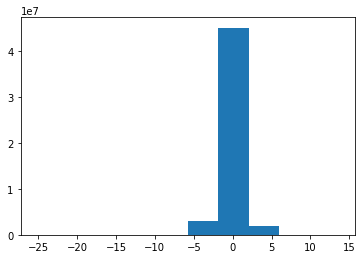

In [15]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 

# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo04.mrc') 
# out_filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo04_dummy.mrc')

cet_path = os.path.join(PARENT_PATH, 'data/nnUnet/nifti_files/tomo04_bin4_denoised_0000.nii.gz') 
out_filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo04_cryoCAREDummy.mrc')

# cet_path = os.path.join(ISONET_PATH, 'RAW_dataset/RAW_allTomos_deconv/tomo04.mrc') 
# out_filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo04_deconvDummy.mrc')

# cet_path = os.path.join(ISONET_PATH, 'RAW_dataset/RAW_allTomos_deconv/tomo02.mrc') 
# out_filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_deconvDummy.mrc')

# cet_path = os.path.join(PARENT_PATH, 'data/nnUnet/nifti_files/tomo02_bin4_denoised_0000.nii.gz') 
# out_filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_cryoCAREDummy.mrc')


# n = 4
# cet_path = os.path.join(PARENT_PATH, 'data/shrec2021/model_%i/reconstruction.mrc' %n)
# out_filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/shrec2021_model%i_dummy.mrc' %n)
# cet_path = os.path.join(PARENT_PATH, 'data/shrec2021/model_%i/grandmodel.mrc' %n)
# out_filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/shrec2021_model%i_gtDummy.mrc' %n)


tomo_data = read_array(cet_path)
print('Original Tomogram shape:', tomo_data.shape)

z,y,x = tomo_data.shape

dummy_tomo = tomo_data[z//4:3*z//4, y//4:3*y//4, x//4:3*x//4]
print('Output Tomogram shape:', dummy_tomo.shape)

plt.hist(dummy_tomo.flatten())

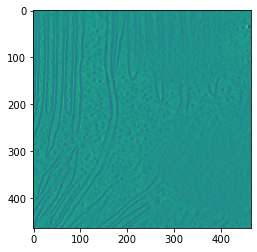

In [16]:
plt.imshow(dummy_tomo[dummy_tomo.shape[0]//2])

In [17]:
write_array(dummy_tomo, out_filename)

# Noisy versions

## Poisson + Gauss

In [18]:
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_cryoCAREDummy.mrc')
cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo04_cryoCAREDummy.mrc')
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomoPhantom_model14.mrc')
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/shrec2021_model4_dummy.mrc')
tomo_data = read_array(cet_path)
tomo_data = standardize(tomo_data)
m = tomo_data.min()
tomo_data -= m
tomo_shape = np.array(tomo_data.shape)
tomo_shape

array([232, 464, 464])

In [19]:
noisy_tomo = random_noise(tomo_data, mode='poisson', clip=False)
noisy_tomo = random_noise(noisy_tomo, mode='gaussian', var=5, mean=0, clip=False)

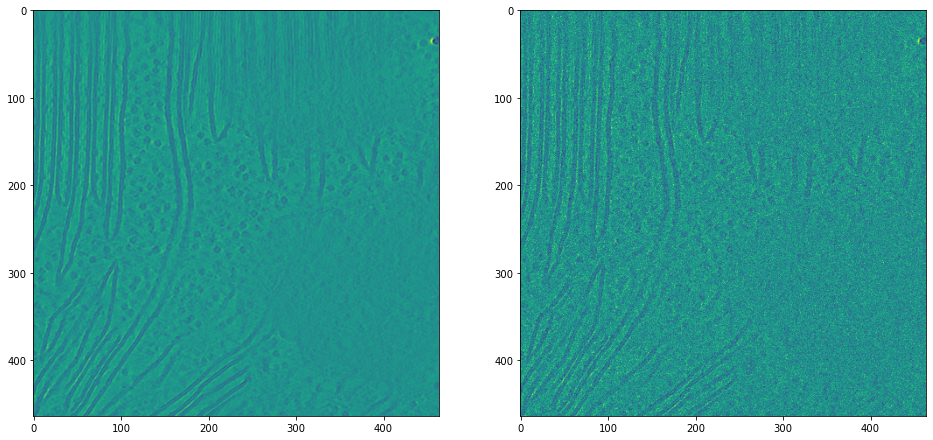

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 12))
ax0.imshow(tomo_data[tomo_shape[0]//2])
ax1.imshow(noisy_tomo[tomo_shape[0]//2])

(array([4.0000000e+00, 2.3000000e+01, 1.1100000e+02, 5.2800000e+02,
        6.6830000e+03, 3.0445020e+06, 4.5011352e+07, 1.8772490e+06,
        8.1660000e+03, 5.4000000e+01]),
 array([ 0.       ,  3.3301322,  6.6602645,  9.9903965, 13.320529 ,
        16.650661 , 19.980793 , 23.310926 , 26.641058 , 29.971191 ,
        33.301323 ], dtype=float32),
 <BarContainer object of 10 artists>)

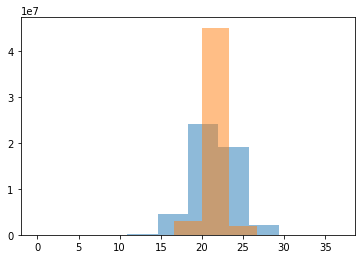

In [21]:
plt.hist(noisy_tomo.flatten(), alpha=0.5)
plt.hist(tomo_data.flatten(), alpha=0.5)

In [22]:
filename = cet_path.replace('.mrc', '_noisyGaussPoiss.mrc')
with mrcfile.new(filename, overwrite=True) as mrc:
    mrc.set_data(np.float32(noisy_tomo))

## Structured Noise

In [23]:
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_cryoCAREDummy.mrc')
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomoPhantom_model14.mrc')
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/shrec2021_model4_dummy.mrc')
cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo04_cryoCAREDummy.mrc')

tomo_data = read_array(cet_path)
tomo_data = standardize(tomo_data)
m = tomo_data.min()
tomo_data -= m
tomo_shape = np.array(tomo_data.shape)
tomo_shape

array([232, 464, 464])

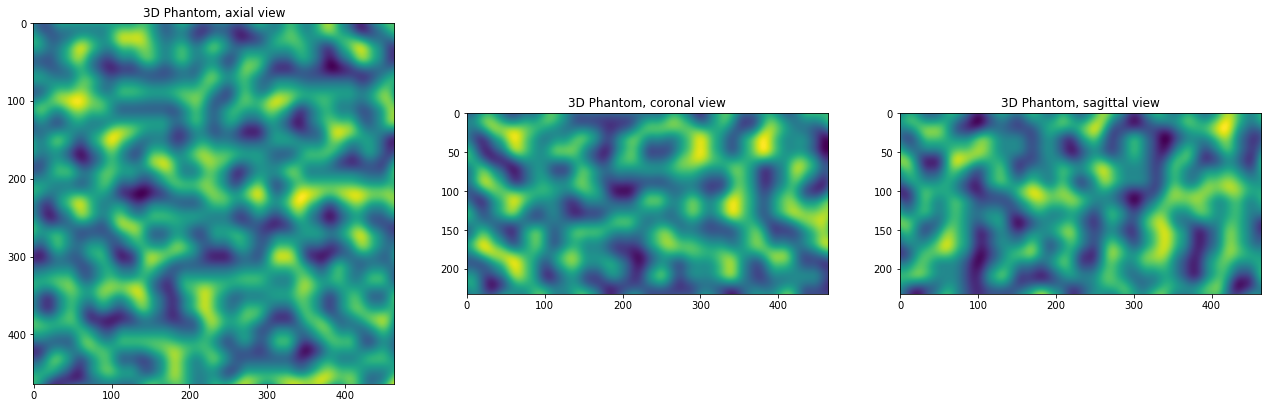

In [24]:
shape = tomo_shape
N_threads = 4

perlin = fns.Noise(seed=0, numWorkers=N_threads)
perlin.frequency = 0.025 # regular perlin
# perlin.frequency = 0.08 # highFreq perlin
perlin.noiseType = fns.NoiseType.Perlin
perlin.fractal.octaves = 4
perlin.fractal.lacunarity = 5
perlin.fractal.gain = 0.45
perlin.perturb.perturbType = fns.PerturbType.NoPerturb
noise = perlin.genAsGrid(shape)
noise = (noise-noise.min())/(noise.max()-noise.min())

zidx, yidx, xidx = tomo_shape//2

plt.figure(figsize=(22, 12)) 
plt.subplot(131)
plt.imshow(noise[zidx,:,:])
plt.title('3D Phantom, axial view')

plt.subplot(132)
plt.imshow(noise[:,yidx,:])
plt.title('3D Phantom, coronal view')

plt.subplot(133)
plt.imshow(noise[:,:,xidx])
plt.title('3D Phantom, sagittal view')
plt.show()

(array([   44885.,   830843.,  3835850.,  8552125., 11888463., 11777075.,
         8368216.,  3732470.,   880479.,    38266.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

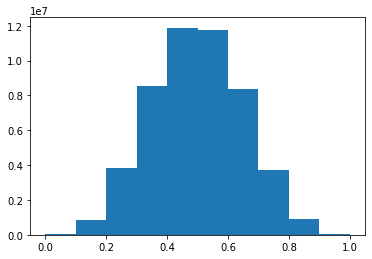

In [25]:
plt.hist(noise.flatten())

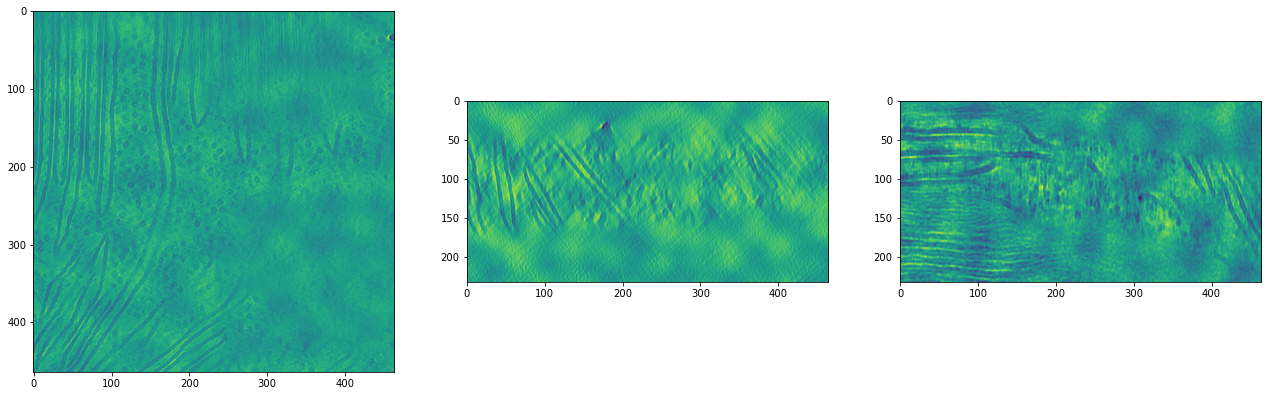

In [26]:
thresh = 0.0
noisy_tomo = np.where(noise<thresh, thresh, noise)
noisy_tomo = tomo_data+5*noisy_tomo

zidx, yidx, xidx = tomo_shape//2

plt.figure(figsize=(22, 12)) 
plt.subplot(131)
plt.imshow(noisy_tomo[zidx,:,:])

plt.subplot(132)
plt.imshow(noisy_tomo[:,yidx,:])


plt.subplot(133)
plt.imshow(noisy_tomo[:,:,xidx])
plt.show()

(array([4.0000000e+00, 2.3000000e+01, 1.1100000e+02, 5.2800000e+02,
        6.6830000e+03, 3.0445020e+06, 4.5011352e+07, 1.8772490e+06,
        8.1660000e+03, 5.4000000e+01]),
 array([ 0.       ,  3.3301322,  6.6602645,  9.9903965, 13.320529 ,
        16.650661 , 19.980793 , 23.310926 , 26.641058 , 29.971191 ,
        33.301323 ], dtype=float32),
 <BarContainer object of 10 artists>)

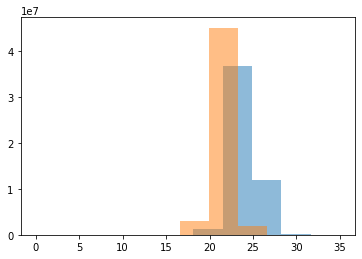

In [27]:
plt.hist(noisy_tomo.flatten(), alpha=0.5)
plt.hist(tomo_data.flatten(), alpha=0.5)

In [28]:
if perlin.frequency == 0.025:
    filename = cet_path.replace('.mrc', '_noisyPerlin.mrc')
if perlin.frequency == 0.08:
    filename = cet_path.replace('.mrc', '_noisyPerlinHighFreq.mrc')
with mrcfile.new(filename, overwrite=True) as mrc:
    mrc.set_data(np.float32(noisy_tomo))

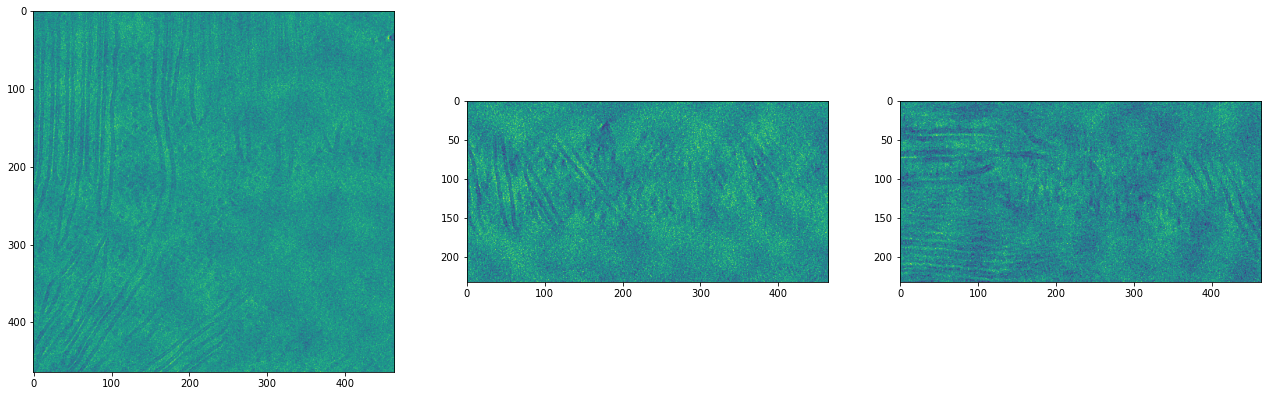

In [29]:
noisier_tomo = random_noise(tomo_data, mode='poisson', clip=False)
noisier_tomo = random_noise(noisier_tomo, mode='gaussian', var=5, mean=0, clip=False)
noisier_tomo = noisier_tomo+5*noise

zidx, yidx, xidx = tomo_shape//2

plt.figure(figsize=(22, 12)) 
plt.subplot(131)
plt.imshow(noisier_tomo[zidx,:,:])

plt.subplot(132)
plt.imshow(noisier_tomo[:,yidx,:])


plt.subplot(133)
plt.imshow(noisier_tomo[:,:,xidx])
plt.show()

In [30]:
if perlin.frequency == 0.025:
    filename = cet_path.replace('.mrc', '_noisyGaussPoissPerlin.mrc')
if perlin.frequency == 0.08:
    filename = cet_path.replace('.mrc', '_noisyGaussPoissPerlinHighFreq.mrc')

with mrcfile.new(filename, overwrite=True) as mrc:
    mrc.set_data(np.float32(noisier_tomo))